In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from math import exp

from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing

from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import calc_fixp
from ruspy.estimation.estimation_cost_parameters import lin_cost
from ruspy.estimation.estimation_cost_parameters import cost_func
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix
from ruspy.estimation.estimation_cost_parameters import choice_prob

## Quentin Andre

First I replicate the plot in cell 133 of [Quentin Andre](https://github.com/QuentinAndre/John-Rust-1987-Python/blob/master/Data%20Generation%20and%20Likelihood%20Fit.ipynb)

In [2]:
num_states = 70
params_que = [20, 500] # Needs to be 500 has scale factor is 0.001 and in quentin its 0.5
costs_que = cost_func(num_states, lin_cost, params_que)
que_trans = np.array([0.36, 0.48, 0.16])
trans_mat_que = create_transition_matrix(num_states, que_trans)

In [3]:
beta = 0
ev_que_0 = calc_fixp(num_states, trans_mat_que, costs_que, beta)
choice_que_0 = choice_prob(ev_que_0, params_que, beta)

In [4]:
beta = 0.75
ev_que_75 = calc_fixp(num_states, trans_mat_que, costs_que, beta)
choice_que_75 = choice_prob(ev_que_75, params_que, beta)

[]

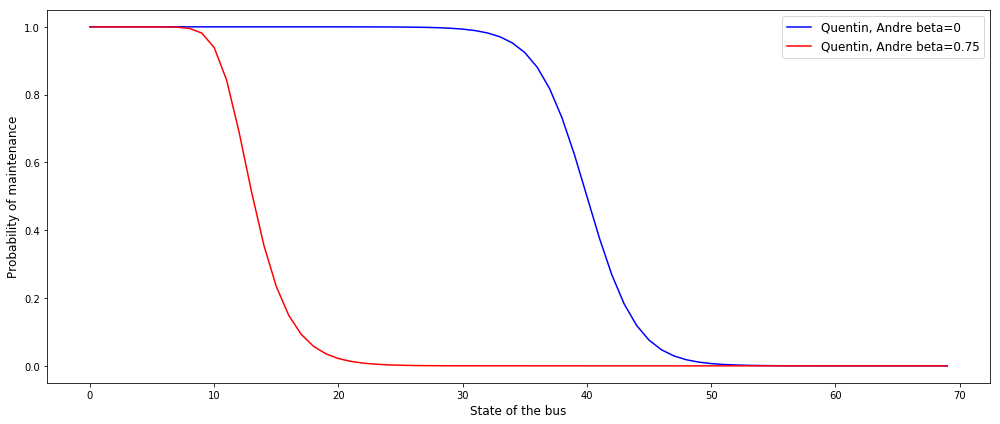

In [5]:
states = range(num_states)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_que_0[:, 0], color='blue', label='Quentin, Andre beta=0')
ax.plot(states, choice_que_75[:, 0], color='red', label='Quentin, Andre beta=0.75')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

## Rust

Now I do the same plot with the results of Rust. Its very important to say, that in a simulation the maximal state reached by a bus was just below 150 and I plotted here dwon there up to 500 states. That shows, that the maintainance costs have almost no effect on the decision. This also very intuituve to the fact, that in quentin's model the slope of the linear cost function was 500 * 0.001 = 0.5 and here it is 2.29 * 0.001 = 0.00229. 

In [6]:
# Prepare the raw data.
data_reading()

In [12]:
beta = 0.9999
#Initilize a dictionary with values needed on the way.
init_dict = {
    'groups': 'group_4',
    'beta': beta,
    'maint_func': 'linear',
    'binsize': 5000,
    'states': 90,
}

In [13]:
repl_data = data_processing(init_dict)
trans_results, cost_results = estimate(init_dict, repl_data)
print(trans_results, cost_results)

     fun: 3140.570557231583
     jac: array([-4291.96844482, -4292.02462769, -4291.81420898])
 message: 'Optimization terminated successfully.'
    nfev: 158
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([0.39189477, 0.59529015, 0.01281509])       fun: 163.5858389821685
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68434189e-06, -4.17799129e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 10
   status: 0
  success: True
        x: array([10.07744728,  2.2940148 ])


In [ ]:
params = cost_results['x']
ml_trans = np.array(trans_results['x'])

In [18]:
num_states = 1000
costs = cost_func(num_states, lin_cost, params)
trans_mat_ml = create_transition_matrix(num_states, ml_trans)
ev_ml = calc_fixp(num_states, trans_mat_ml, costs, beta)
choice_ml = choice_prob(ev_ml, params, beta)

[]

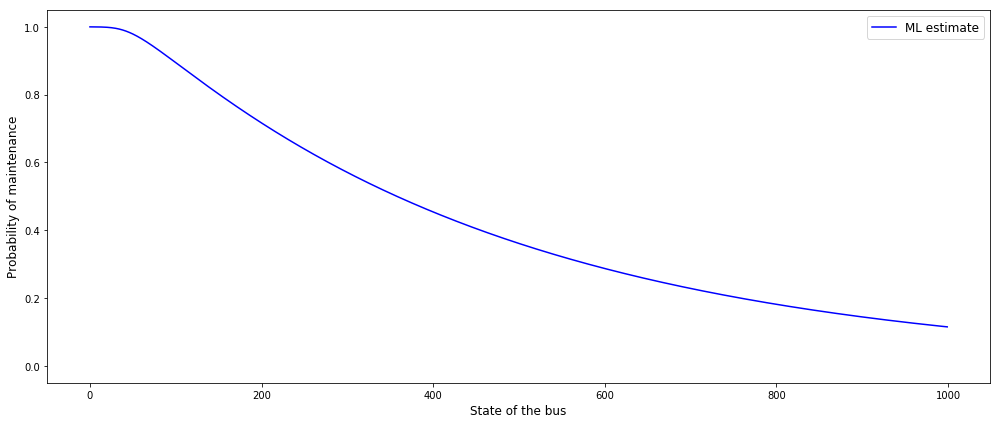

In [19]:
states = range(num_states)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_ml[:, 0], color='blue', label='ML estimate')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

In [32]:
max_state = repl_data.state.max()
real_maint = [0] * (max_state + 1)
real_repl = [0] * (max_state + 1)
for i in range(max_state + 1):
    df = repl_data[repl_data.state == i]
    real_repl[i] = df.decision.sum() / df.shape[0]
    real_maint[i] = 1 - real_repl[i]
    

In [33]:
num_states = 90
costs = cost_func(num_states, lin_cost, params)
trans_mat_ml = create_transition_matrix(num_states, ml_trans)
ev_ml = calc_fixp(num_states, trans_mat_ml, costs, beta)
choice_ml = choice_prob(ev_ml, params, beta)

[]

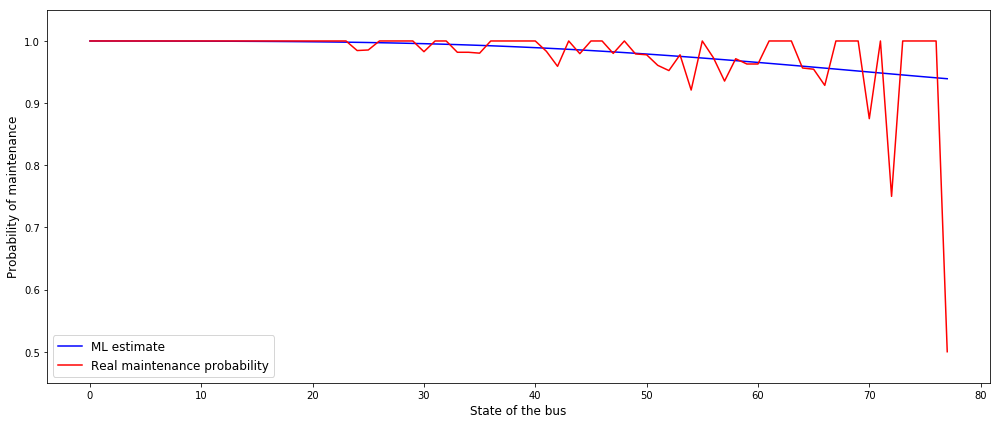

In [35]:
states = range(max_state + 1)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0.45, 1.05])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_ml[:max_state + 1, 0], color='blue', label='ML estimate')
ax.plot(states, real_maint, color='red', label='Real maintenance probability')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()

[]

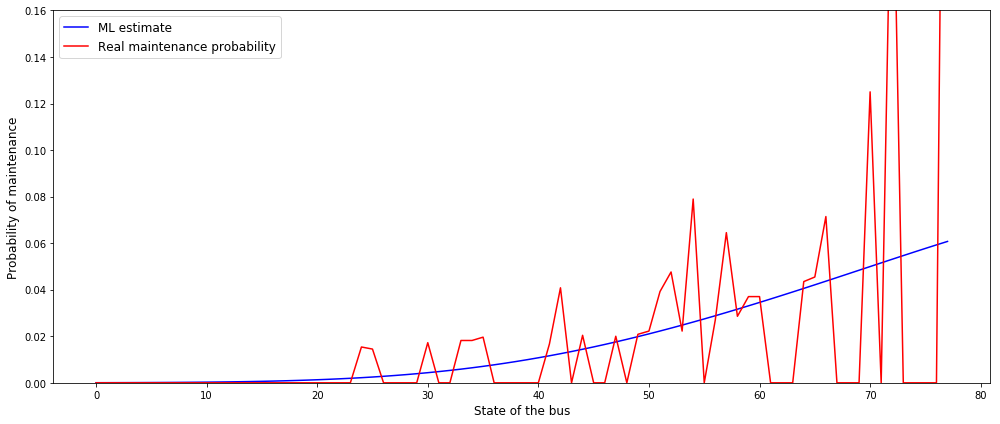

In [38]:
states = range(max_state + 1)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 0.16])
ax.set_ylabel(r"Probability of maintenance",fontsize=12)
ax.set_xlabel(r"State of the bus", fontsize=12)
ax.plot(states, choice_ml[:max_state + 1, 1], color='blue', label='ML estimate')
ax.plot(states, real_repl, color='red', label='Real maintenance probability')


plt.legend()
ax.legend(fontsize=12)
plt.tight_layout()

plt.plot()